In [81]:
import numpy as np
import nltk
import os
import pysrt
import re
from nltk.corpus import stopwords
import gensim
from sklearn.cluster import KMeans
from sklearn.preprocessing import minmax_scale
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import pandas as pd

def clean_sub(name):
    sub_clean=[]
    i = 0
    for file in os.listdir('./0'):
        filepath = os.path.join('0/', file)
        f = open(filepath, 'r')
        subs = pysrt.open(filepath, encoding='iso-8859-1')
        list_sub=[]
        for sub in subs:
            list_sub.append(sub.text)
        text_sub= ' '.join(list_sub)
        clean1 = re.sub('<.+?>', ' ', text_sub) #membersihkan kata italic
        clean2 = re.sub("\n", " ", clean1) #as you can see
        clean3 = re.sub("[^0-9a-zA-Z\']+", ' ', clean2) #membuat semua tanda aneh hilang kecuali itu
        sub_clean.append(clean3)
        f.close()
        if i == int(name):  #buat testing
            break
        i +=1
    sub_clean= [' '.join(sub_clean)]
    return sub_clean

In [2]:
def cleaninf(t):
    words_clean = nltk.word_tokenize(clean_sub(t)[0].lower())
    ps = nltk.stem.PorterStemmer()
    words_stemmed = [ps.stem(w) for w in words_clean]
    stop = stopwords.words("english") + ['\'re', '\'s', 'n\'t', '\'m', '\'ll', '\'d', '\'ve']
    stops = set(stop)
    clean_word = []
    for w in words_stemmed:
        if w not in stops:
#             print(w)
            clean_word.append(w)
    return clean_word

In [3]:
# len(clean_word)
# 'littlefing' in clean_word

In [4]:
# fdist = nltk.FreqDist(clean_word)
# print(fdist)

In [5]:
def w2v(t):
    model = gensim.models.Word2Vec([cleaninf(t)], size=100, window=10, min_count=10, workers=8)
    return model

In [6]:
# print(model.wv.most_similar(positive=['jon'], topn = 10))

In [49]:
def kmean(model):
    global kmeans_clustering
    global idx
    word_vectors = model.wv.vectors
    num_clusters = 7

    kmeans_clustering = KMeans( n_clusters = num_clusters )
    idx = kmeans_clustering.fit_predict( word_vectors )
    print('ini idx asli', idx)
#     return list(idx)

In [51]:
def print_kmean(model):
    global idx
    idx = list(idx)
    names = model.wv.index2word
    print('ini namesss', names)
    word_centroid_map = {names[i]: idx[i] for i in range(len(names))}

    for cluster in range(7):
        print("\nCluster {}".format(cluster))

        words = []
        for i in range(0,len(list(word_centroid_map.values()))):
            if( list(word_centroid_map.values())[i] == cluster ):
                words.append(list(word_centroid_map.keys())[i])
        print(words)

In [9]:
# word_centroid_map['jorah']


    

In [10]:
def stem_artis():
    artist = 'Eddard Ned Robert Jaime Catelyn Cersei Daenerys Jorah Viserys Jon Sansa Arya Robb Theon Bran Joffrey Sandor Hound Tyrion Khal Drogo Petyr Littlefinger Davos Samwell Stannis Melisandre Jeor Bronn Varys Shae Margaery Tywin Talisa Ygritte Gendry Tormund Brienne Tarth Ramsay Gilly Daario Missandei Ellaria Tommen Jaqen Roose High Sparrow'
    list_artis = list(artist.split())
    ps = nltk.stem.PorterStemmer()
    list_artis = [ps.stem(w) for w in list_artis]
    return list_artis

In [11]:
def dimension_reduction(model):
    global vocab
    global vect
    vocab = model.wv.vocab
    vect = model.wv.vectors
    re_dim = TSNE().fit_transform(vect)
    redim=re_dim
#     #normalisasi
#     redim = np.array(re_dim)
#     redim = re_dim.reshape(2*len(re_dim), 1)
#     redim = minmax_scale(redim)
#     redim = redim.reshape(len(re_dim), 2)
    
#     #menjadikan ned sebagai center
#     a = list(vocab)
#     x_ned = redim[a.index('ned'), 0]
#     y_ned = redim[a.index('ned'), 1]
#     redim[:,0] = (redim[:,0] - x_ned)*100
#     redim[:,1] = (redim[:,1] - y_ned)*100
    
#     #rotation matrix so make it constant
#     if 'robert' in a:
#         x_rob = redim[a.index('robert'), 0]
#         y_rob = redim[a.index('robert'), 1]
#         r = np.sqrt(x_rob**2 + y_rob**2)
#         sin = x_rob/r
#         cos = y_rob/r
#         matrix_rotation = [[cos, sin], [-sin, cos]]
#         redim = np.matmul(redim, matrix_rotation)

    #bikin df
    df = pd.DataFrame()
    df['word'] = vocab
    df['x']= redim[:,0]
    df['y'] = redim[:,1]
    return df

In [12]:
def plot_kmean(df):
    global kmeans_clustering
    fig, ax = plt.subplots()
#     print(df)
    ax.scatter(df['x'], df['y'], s = 1, c=kmeans_clustering.labels_.astype(float))
#     print(c)

In [13]:
def df_art(df):
    l_artist = []
    l_artistx = []
    l_artisty = []
    list_artis = stem_artis()
    for artis in list_artis:
        artis = artis.lower()
        if artis in vocab:
            l_artist.append(artis)
            l_artistx.append(df.loc[artis]['x'])
            l_artisty.append(df.loc[artis]['y'])
    df_artist = pd.DataFrame()
    df_artist['word'] = l_artist
    df_artist['x'] = l_artistx
    df_artist['y'] = l_artisty
    return df_artist

In [78]:
def plot(df_artist, df):
    fig, ax = plt.subplots(figsize=(20,10))
#     ax.scatter(df_artist['x'], df_artist['y'])
#     colors = matplotlib.cm.rainbow(np.linspace(0, 1, len(df['x'])))
#     cs = [colors[i//len(X)] for i in range(len(Ys)*len(X))]
    ax.scatter(df['x'], df['y'], s = 60, c=idx)

    for i, txt in enumerate(df_artist['word']):
        ax.annotate(txt, (df_artist['x'][i], df_artist['y'][i]), color = "red", size = 13)
        print('artis: %s, dengan x: %.2f, y: %.2f' %(txt, df_artist['x'][i], df_artist['y'][i]))
#     ax.set_ylim(-100, 100)
#     ax.set_xlim(-100, 100)
    
    image = fig.canvas.draw()       # draw the canvas, cache the renderer
#     image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
#     image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))
    plt.savefig('tes.png')
    return image

67


C:\Users\aziza\AppData\Roaming\Python\Python37\site-packages\gensim\models\base_any2vec.py:743: UserWarning: C extension not loaded, training will be slow. Install a C compiler and reinstall gensim for fast training.
  "C extension not loaded, training will be slow. "


ini idx asli [6 6 6 ... 2 2 2]
artis: eddard, dengan x: -48.11, y: -13.81
artis: ned, dengan x: -38.46, y: -31.27
artis: robert, dengan x: -43.37, y: 0.05
artis: jaim, dengan x: -7.86, y: -9.90
artis: catelyn, dengan x: -38.65, y: -20.40
artis: cersei, dengan x: 16.09, y: 34.25
artis: daeneri, dengan x: -34.47, y: -4.38
artis: jorah, dengan x: -19.93, y: 0.70
artis: viseri, dengan x: -34.00, y: -11.63
artis: jon, dengan x: -50.09, y: -0.13
artis: sansa, dengan x: -36.60, y: -14.80
artis: arya, dengan x: -38.82, y: -20.87
artis: robb, dengan x: -41.32, y: -19.74
artis: theon, dengan x: 5.31, y: 35.70
artis: bran, dengan x: -19.38, y: -25.53
artis: joffrey, dengan x: -26.10, y: 11.12
artis: hound, dengan x: -8.92, y: 14.97
artis: tyrion, dengan x: -41.16, y: -25.00
artis: khal, dengan x: -20.91, y: -2.61
artis: drogo, dengan x: -37.40, y: -8.80
artis: petyr, dengan x: 31.32, y: 37.74
artis: littlefing, dengan x: 10.45, y: 40.63
artis: davo, dengan x: 2.63, y: 30.75
artis: samwel, dengan 

['king', 'go', 'come', 'us', 'need', 'take', 'back', 'stark', 'ca', 'north', 'night', 'watch', 'wall', 'help', 'land', 'armi', 'command', 'jon', 'winterfel', 'stop', 'castl', 'snow', 'hold', 'door', 'black', 'wildl', 'hodor', 'gate', 'bran', 'south', 'bolton', 'march']

Cluster 4
['close', 'hurt', 'hair', 'sleep', 'choic', 'readi', 'insid', 'bad', 'ago', 'walker', 'mormont', 'hunt', 'sam', 'set', 'becom', 'poor', 'worri', 'beg', 'princess', 'choos', 'welcom', 'none', 'davo', 'casterli', 'touch', 'tonight', 'terribl', 'wors', 'nice', 'pray', 'meant', 'sound', '10', 'hit', 'steel', 'claim', 'throat', 'cunt', 'longer', 'arm', 'miss', 'sing', 'went', 'teach', 'wolf', 'squir', 'idea', 'anymor', 'least', 'vow', 'liar', 'stone', 'less', 'worth', 'chang', 'surviv', 'reek', 'five', 'destroy', 'sort', 'tommen', 'littlefing', 'yeah', 'hide', 'troubl', 'possibl', 'hundr', 'mouth', 'travel', 'support', 'brienn', 'dream', 'apolog', 'fail', 'unless', 'book', 'tarli', 'outsid', 'damn', 'dear', 'wear',

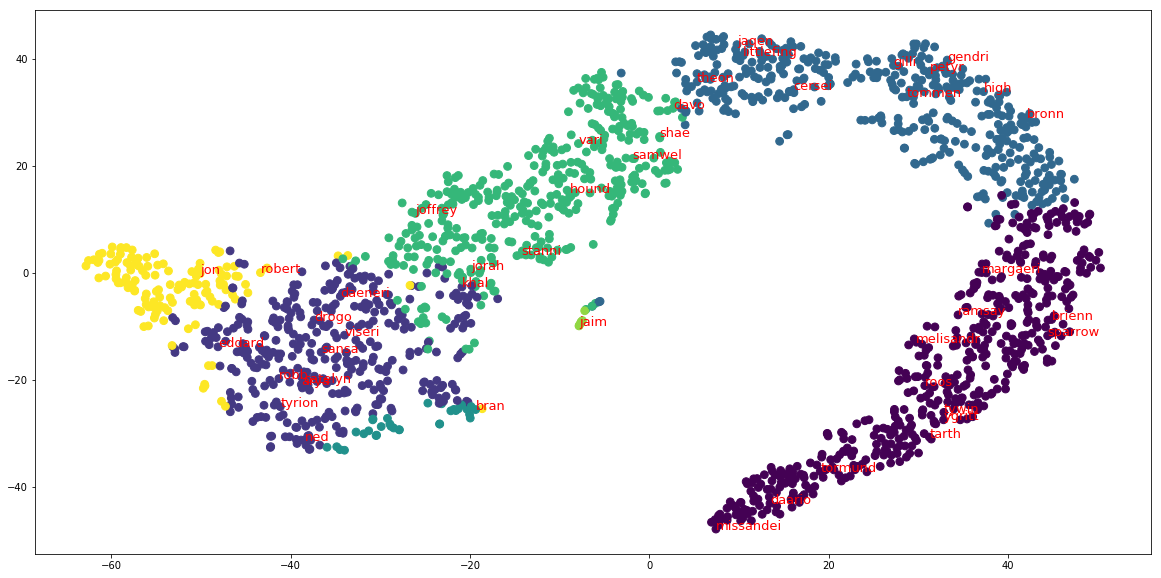

In [82]:
def main(i):
    print(i)
    model = w2v(i)
    df = dimension_reduction(model)
    df_artist = df_art(df)
    kmean(model)
    image = plot(df_artist, df)
    print_kmean(model)    
    return image, model

a, model= main(len(os.listdir('./0')))
a

In [ ]:
# for i in range(len(os.listdir('./0'))):
#     main(i)

In [ ]:
# import imageio
# imageio.mimsave('./powers.gif', [main(i) for i in range(len(os.listdir('./0')))], fps=4)

In [ ]:
print_kmean()

In [86]:
model.wv.most_similar(positive=['jon', 'snow'], negative=['stark'], topn = 10)

C:\Users\aziza\AppData\Roaming\Python\Python37\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('wall', 0.9379985928535461),
 ('castl', 0.9286609888076782),
 ('night', 0.9241071343421936),
 ('black', 0.9118342399597168),
 ('watch', 0.9060572981834412),
 ('wildl', 0.8965723514556885),
 ('back', 0.854850172996521),
 ('us', 0.848949134349823),
 ('dead', 0.8371561169624329),
 ('south', 0.834764301776886)]